So far, we've been comparing data with at least one one numerical(continuous) column and one categorical(nominal) column. So what happens if we want to determine the statistical significance of two independent categorical groups of data?

This is where the Chi-squared test for independence is useful.

### Chi-Squared Test Assumptions

We'll be looking at data from the census in 1994. Specifically, we are interested in the relationship between 'sex' and 'hours-per-week' worked. Click [here](https://archive.ics.uci.edu/ml/datasets/Census+Income) for the documentation and citation of the data. First let's get the assumptions out of the way:

+ There must be different participants in each group with no participant being in more than one group. In our case, each individual can only have one 'sex' and can not be in multiple workhour categories.
+ Random samples from the population. In our case, the census is a good representation of the population.

### Data Exploration

For the sake of this example, we'll convert the numerical column 'hours-per-week' into a categorical column using pandas. Then we'll assign 'sex' and 'hours_per_week_categories' to a new dataframe.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
%matplotlib inline

cols = ['age', 'workclass', 'fnlwg', 'education', 'education-num', 
        'marital-status','occupation','relationship', 'race','sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv('census.csv', names=cols)

#Create a column for work hour categories.
def process_hours(df):
    cut_points = [0,9,19,29,39,49,1000]
    label_names = ["0-9","10-19","20-29","30-39","40-49","50+"]
    df["hours_per_week_categories"] = pd.cut(df["hours-per-week"],
                                             cut_points,labels=label_names)
    return df

data = process_hours(data)
workhour_by_sex = data[['sex', 'hours_per_week_categories']]
workhour_by_sex.head()

,sex,hours_per_week_categories
0,Male,40-49
1,Male,10-19
2,Male,40-49
3,Male,40-49
4,Female,40-49


In [2]:
workhour_by_sex['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [3]:
workhour_by_sex['hours_per_week_categories'].value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

### The Null and Alternate Hypotheses

Recall that we are interested in knowing if there is a relationship between 'sex' and 'hours_per_week_categories'. In order to do so, we would have to use the Chi-squared test. But first, let's state our null hypothesis and the alternative hypothesis.

$ H_0 :  \text{There is no statistically significant relationship between sex and the # of hours per week worked.} $

$ H_a :  \text{There is a statistically significant relationship between sex and the # of hours per week worked.} $


### Constructing the Contingency Table

The next step is to format the data into a frequency count table. This is called a <b>Contingency Table</b>, we can accomplish this by using the pd.crosstab() function in pandas.

In [4]:
contingency_table = pd.crosstab(
    workhour_by_sex['sex'],
    workhour_by_sex['hours_per_week_categories'],
    margins = True
)
contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


Each cell in this table represents a frequency count. For example, the intersection of the 'Male' row and the '10-19' column of the table would represent the number of males who works 10-19 hours per week from our sample data set. The intersection of the 'All' row and the '50+' column would represent the total number of people who works 50+ hours a week.

### Visualizing the Contingency Table with a Stacked Bar Chart

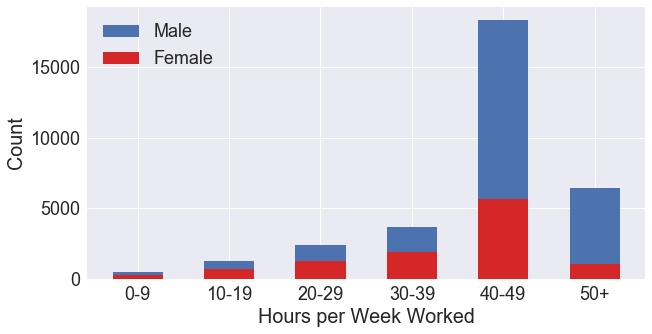

In [5]:
#Assigns the frequency values
malecount = contingency_table.iloc[0][0:6].values
femalecount = contingency_table.iloc[1][0:6].values

#Plots the bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
categories = ["0-9","10-19","20-29","30-39","40-49","50+"]
p1 = plt.bar(categories, malecount, 0.55, color='#d62728')
p2 = plt.bar(categories, femalecount, 0.55, bottom=malecount)
plt.legend((p2[0], p1[0]), ('Male', 'Female'))
plt.xlabel('Hours per Week Worked')
plt.ylabel('Count')
plt.show()

The chart above visualizes our sample data from the census. If there is truly no relationship between sex and the number of hours per week worked. Then the data would show an even ratio split between 'Male' and 'Female' for each time category. For example, if 5% of the females worked 50+ hours, we would expect the same percentage for males who worked 50+ hours.


### The Chi-Squared Test for Independence - Calculation with Numpy

In order to determine whether we accept or reject the null hypothesis. We have to compute p-value similar to the welch's t-test and ANOVA. For testing with two categorical variables, we will use the Chi-squared test.

$$ X^2 = \frac{(observed - expected)^2} {(expected)}$$

Where $X^2$ is the test statistic, $observecd$ are values we have in the contingency table, $expected$ are values we would expect assuming the null hypothesis is true. Theoretically speaking, if all the expected values are equal to the observed values, then the $X^2$ statistic will be 0. As a result, the null hypothesis will be retained.

First, let's put the observed values into a one dimensional array, reading the contingency table from left to right then top to bottom.

In [6]:
f_obs = np.append(contingency_table.iloc[0][0:6].values, contingency_table.iloc[1][0:6].values)
f_obs

array([  235,   671,  1287,  1914,  5636,  1028,   223,   575,  1105,
        1753, 12700,  5434], dtype=int64)

Next, we need to calculate the expected values. The expected values assume that null hypothesis is true. We would need to calculate values if there is an equal percentage of males and females for each category. For example, this is how we would calculate the expected value for the top left cell:

$$ \text{Expected # of Females in the '0-9' Category} = \frac{\text{Total # of Females} * \text{Number of People in the '0-9' Category}} {\text{Total # of People}}$$

In [7]:
row_sums = contingency_table.iloc[0:2,6].values
row_sums

array([10771, 21790], dtype=int64)

In [8]:
col_sums = contingency_table.iloc[2,0:6].values
col_sums

array([  458,  1246,  2392,  3667, 18336,  6462], dtype=int64)

In [9]:
total = contingency_table.loc['All', 'All']

f_expected = []
for j in range(2):
    for i in col_sums:
        f_expected.append(i*row_sums[j]/total)
f_expected

[151.50388501581648,
 412.1699579251252,
 791.2604649734345,
 1213.0234636528362,
 6065.44811277295,
 2137.5941156598383,
 306.4961149841835,
 833.8300420748749,
 1600.7395350265656,
 2453.976536347164,
 12270.551887227051,
 4324.405884340162]

Now that we have all our observed and expected values, we can just plug everything into the Chi-squared test formula.

In [10]:
chi_squared_statistic = ((f_obs - f_expected)**2/f_expected).sum()
print('Chi-squared Statistic: {}'.format(chi_squared_statistic))

Chi-squared Statistic: 2287.190943926107


#### Degrees of Freedom

Similar to the Welch's t-test, we would have to calculate the degrees of freedom before we can determine the p-value.

$$ DoF =  {(\text{Number of rows} - 1)}*{(\text{Number of columns} - 1)}$$

In [11]:
dof = (len(row_sums)-1)*(len(col_sums)-1)
print("Degrees of Freedom: {}".format(dof))

Degrees of Freedom: 5


Now we are ready to look into the Chi-squared distribution [table](http://www.itl.nist.gov/div898/handbook/eda/section3/eda3674.htm). The cut off for a p-value of 0.05 was 11.070. Our $X^2$ statistic was so large that the p-value is approximately zero. So we have evidence against the null hypothesis.

### The Chi-Squared Test for Independence - Using Scipy

Now that we've gone through all the calculations, it is time to look for shortcuts. Scipy has a function that plugs in all the values for us. Click [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) for the documentation.

All we need to do is format the observed values into a two-dimensional array and plug it into the function.

In [12]:
f_obs = np.array([contingency_table.iloc[0][0:6].values,
                  contingency_table.iloc[1][0:6].values])
f_obs

array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]], dtype=int64)

In [13]:
from scipy import stats
stats.chi2_contingency(f_obs)[0:3]

(2287.190943926107, 0.0, 5)

The results were exactly the same as our calculations with Numpy. The $X^2$ = ~2287, p-value = ~0 and degrees of freedom = 5.

### Conclusions

With a p-value < 0.05 , we can reject the null hypothesis. There is definitely some sort of relationship between 'sex' and the 'hours-per-week' column. We don't know what this relationship is, but we do know that these two variables are not independent of each other.

---

The files used for this article can be found in my [GitHub repository](https://github.com/sengkchu/codingdisciple.content/tree/master/Learning%20data%20science/Learning/Studying%20Statistics/Chi-Squared%20Test%20for%20Independence).